In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Define helper functions

In [3]:
def split_d1(row, branching, leaves):
    if row[branching[0]] == 0:
        return row[f'y{leaves[0]}']
    else:
        return row[f'y{leaves[1]}']
    
def split_d2(row, branching, leaves):
    if row[branching[0]] == 0:
        if row[branching[1]] == 0:
            return row[f'y{leaves[0]}']
        else:
            return row[f'y{leaves[1]}']
    else:
        if row[branching[2]] == 0:
            return row[f'y{leaves[2]}']
        else:
            return row[f'y{leaves[3]}']
        
def split_d3(row, branching, leaves):
    if row[branching[0]] == 0:
        if 'pruned' not in branching[1]:
            if row[branching[1]] == 0:
                if 'pruned' not in branching[3]:
                    if row[branching[3]] == 0:
                        return row[f'y{leaves[0]}']
                    else:
                        return row[f'y{leaves[1]}']
                else:
                    return row[f'y{branching[3][-1]}']
            else:
                if 'pruned' not in branching[4]:
                    if row[branching[4]] == 0:
                        return row[f'y{leaves[2]}']
                    else:
                        return row[f'y{leaves[3]}']
                else:
                    return row[f'y{branching[4][-1]}']
        else:
            return row[f'y{branching[1][-1]}']
    else:
        if 'pruned' not in branching[2]:
            if row[branching[2]] == 0:
                if 'pruned' not in branching[5]:
                    if row[branching[5]] == 0:
                        return row[f'y{leaves[4]}']
                    else:
                        return row[f'y{leaves[5]}']
                else:
                    return row[f'y{branching[5][-1]}']
            else:
                if 'pruned' not in branching[6]:
                    if row[branching[6]] == 0:
                        return row[f'y{leaves[6]}']
                    else:
                        return row[f'y{leaves[7]}']
                else:
                    return row[f'y{branching[6][-1]}']
        else:
            return row[f'y{branching[2][-1]}']
            
def assign_d1(row, branching, leaves):
    if row[branching[0]] == 0:
        return leaves[0]
    else:
        return leaves[1]
    
def assign_d2(row, branching, leaves):
    if row[branching[0]] == 0:
        if row[branching[1]] == 0:
            return int(leaves[0])
        else:
            return int(leaves[1])
    else:
        if row[branching[2]] == 0:
            return int(leaves[2])
        else:
            return int(leaves[3])
        
def assign_d3(row, branching, leaves):
    if row[branching[0]] == 0:
        if 'pruned' not in branching[1]:
            if row[branching[1]] == 0:
                if 'pruned' not in branching[3]:
                    if row[branching[3]] == 0:
                        return int(leaves[0])
                    else:
                        return int(leaves[1])
                else:
                    return int(branching[3][-1])
            else:
                if 'pruned' not in branching[4]:
                    if row[branching[4]] == 0:
                        return int(leaves[2])
                    else:
                        return int(leaves[3])
                else:
                    return int(branching[4][-1])
        else:
            return int(branching[1][-1])
    else:
        if 'pruned' not in branching[2]:
            if row[branching[2]] == 0:
                if 'pruned' not in branching[5]:
                    if row[branching[5]] == 0:
                        return int(leaves[4])
                    else:
                        return int(leaves[5])
                else:
                    return int(branching[5][-1])
            else:
                if 'pruned' not in branching[6]:
                    if row[branching[6]] == 0:
                        return int(leaves[6])
                    else:
                        return int(leaves[7])
                else:
                    return int(branching[6][-1])
        else:
            return int(branching[2][-1])

In [4]:
def rnc(df, df_test, model):
    t_unique = df['t'].unique()
    # for 0.1, y=1 will be minority class and for 0.85, y=0 will be minority class.
    # perform smote to increase the accuracy?
    for t in t_unique:
#         print(i)
        buffer = df[df['t'] == t]
        X_cols = ['Age', 'Height', 'Weight', 'Asian', 'Black.or.African.American', 'Unknown.Race',
             'X.1..1', 'X.1..3', 'X.2..2', 'X.2..3', 'X.3..3', 'Unknown.Cyp2C9', 'Enzyme.Inducer',
             'Amiodarone..Cordarone.', 'VKORC1.A.G', 'VKORC1.A.A', 'VKORC1.Missing']
        X = buffer[X_cols]
#         X = buffer.iloc[:, :17]
        y = buffer['y']
        y_values = y.value_counts()

#         if y_values[1] > 5 and y_values[0] > 5:
#             smote = SMOTE(sampling_strategy=1.0, k_neighbors=5)
#         elif y_values[0] <= 5:
#             smote = SMOTE(sampling_strategy=1.0, k_neighbors=y_values[0] - 1)
#         elif y_values[1] <= 5:
#             smote = SMOTE(sampling_strategy=1.0, k_neighbors=y_values[1]-1)
#         X, y = smote.fit_resample(X, y)
#         print(y.value_counts())

        lr = model.fit(X, y)
        X_test = df_test[X_cols]
#         X_test = df_test.iloc[:, :17]
        df_test['pred' + str(t)] = [i[1] for i in lr.predict_proba(X_test)]

    ## EVALUATE PERFORMANCE
    def find_highest_y(row):
        if row['pred1'] > row['pred0'] and row['pred1'] > row['pred2']:
            return 1
        elif row['pred2'] > row['pred0'] and row['pred2'] > row['pred1']:
            return 2
        else:
            return 0

    def t_opt(row):
        if row['y1'] == 1:
            return 1
        elif row['y2'] == 1:
            return 2
        else:
            return 0

    df_test['t_opt'] = df_test.apply(lambda row: t_opt(row), axis=1)    
    df_test['t_pred'] = df_test.apply(lambda row: find_highest_y(row), axis=1)
    
    return df_test

In [5]:
def evaluate_disparity(df_test, sensitive_group, y_logit, y_opt):
    black = df_test[df_test[sensitive_group] == 1]
    nonblack = df_test[df_test[sensitive_group] == 0]
    
    return black[y_logit].mean() - black[y_opt].mean(), nonblack[y_logit].mean() - nonblack[y_opt].mean()

In [6]:
def evaluate_disparity1(df_test, sensitive_group, y_opt):
    black = df_test[df_test[sensitive_group] == 1]
    nonblack = df_test[df_test[sensitive_group] == 0]
    
    return black[y_opt].mean(), nonblack[y_opt].mean()

In [7]:
def evaluate_disparity_race(df_test, y_opt):
    black = df_test[df_test['Black.or.African.American'] == 1]
    asian = df_test[df_test['Asian'] == 1]
    unknown = df_test[df_test['Unknown.Race'] == 1]
    white = df_test[(df_test['Asian'] == 0) & (df_test['Black.or.African.American'] == 0) \
                   & (df_test['Unknown.Race'] == 0)]
    
    return black[y_opt].mean(), asian[y_opt].mean(), white[y_opt].mean(), unknown[y_opt].mean()

In [29]:
seeds = range(1, 6)
splits = range(1, 6)
r = 0.33

In [13]:
df_train_raw

,id,Gender,Age,Height,Weight,Asian,Black.or.African.American,Unknown.Race,X.1..1,X.1..3,...,Amiodarone..Cordarone.,VKORC1.A.G,VKORC1.A.A,VKORC1.Missing,y,t,y0,y1,y2,prob_t_pred_tree
0,2732,1.0,7,157.48,62.1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0.336667
1,2788,1.0,4,155.00,53.0,1,0,0,1,0,...,0,0,1,0,0,2,1,0,0,0.346333
2,2496,0.0,5,170.18,93.0,0,0,0,0,1,...,0,0,1,0,0,2,1,0,0,0.346333
3,653,0.0,8,147.07,57.0,1,0,0,1,0,...,0,0,1,0,1,0,1,0,0,0.336667
4,5604,1.0,6,167.64,85.9,0,0,0,0,0,...,1,1,0,0,1,1,0,1,0,0.317000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,4601,1.0,5,150.11,70.0,0,0,1,1,0,...,0,0,1,0,1,0,1,0,0,0.336667
2996,415,1.0,5,152.40,47.6,0,0,0,1,0,...,0,1,0,0,0,2,0,1,0,0.346333
2997,1619,1.0,5,151.99,48.0,1,0,0,1,0,...,0,0,1,0,0,2,1,0,0,0.346333
2998,422,1.0,7,163.83,68.0,0,0,0,1,0,...,0,1,0,0,0,2,1,0,0,0.346333


In [12]:
df_train

,id,Gender,Age1.2,Age3.4,Age5.6,Age7,Age8.9,Height1,Height2,Height3,...,VKORC1.Missing,y,t,y0,y1,y2,prob_t_pred_tree,t_d1,t_d2,t_d3
0,2732,1.0,0,0,0,1,1,1,1,1,...,1,0,0,0,1,0,0.336667,1,1,1
1,2788,1.0,0,1,1,1,1,1,1,1,...,0,0,2,1,0,0,0.346333,0,0,0
2,2496,0.0,0,0,1,1,1,0,0,1,...,0,0,2,1,0,0,0.346333,0,0,0
3,653,0.0,0,0,0,0,1,1,1,1,...,0,1,0,1,0,0,0.336667,0,0,0
4,5604,1.0,0,0,1,1,1,0,0,1,...,0,1,1,0,1,0,0.317000,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,4601,1.0,0,0,1,1,1,1,1,1,...,0,1,0,1,0,0,0.336667,0,0,0
2996,415,1.0,0,0,1,1,1,1,1,1,...,0,0,2,0,1,0,0.346333,1,1,1
2997,1619,1.0,0,0,1,1,1,1,1,1,...,0,0,2,1,0,0,0.346333,0,0,0
2998,422,1.0,0,0,0,1,1,0,1,1,...,0,0,2,1,0,0,0.346333,1,1,1


In [28]:
r=0.33
split = 2
fp_data = f'../data/Warfarin_v2/rf_balance_proba_white/seed1'
df_train = pd.read_csv(os.path.join(fp_data, f'data_train_enc_{r}_{split}.csv'))
df_test = pd.read_csv(os.path.join(fp_data, f'data_test_enc_{r}_{split}.csv'))

In [19]:
df_train['White'].sum()

1709

In [21]:
sensitive_group = 'White'

results_outcome = pd.DataFrame(columns=['seed', 'split', 'randomization', 'black_diff', 'non_black_diff', 'tree_depth', 'tree'])
results_interpret = pd.DataFrame(columns=['seed', 'split', 'randomization', 'black_diff', 'non_black_diff', 'tree_depth', 'tree'])
results_exp_outcome = pd.DataFrame(columns=['seed', 'split', 'randomization', 'black_diff', 'non_black_diff', 'tree_depth', 'tree'])
seeds = [1]
splits = [1, 2]
for seed in seeds:
    for split in splits:
        fp_data = f'../data/Warfarin_v2/rf_balance_proba_white/seed{seed}'
        df_train = pd.read_csv(os.path.join(fp_data, f'data_train_enc_{r}_{split}.csv'))
        df_test = pd.read_csv(os.path.join(fp_data, f'data_test_enc_{r}_{split}.csv'))

        df_train_raw = pd.read_csv(os.path.join(fp_data, f'data_train_{r}_{split}.csv'))
        df_test_raw = pd.read_csv(os.path.join(fp_data, f'data_test_{r}_{split}.csv'))

        df_test['White'] = df_test.apply(lambda row: 1 if row['Asian'] == 0 and row['Black.or.African.American'] == 0 \
                                        and row['Unknown.Race'] == 0 else 0, axis=1)
        
        tree = {}
        d=2
        # create tree structure
        branching = ['VKORC1.A.A', 'X.2..3', 'Age3.4']
        leaves = [1, 0, 0, 1]
        tree[2] = {'branching': branching, 'leaves': leaves}
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

        df_test['y_d2'] = df_test.apply(lambda row: split_d2(row, tree[2]['branching'], tree[2]['leaves']), axis=1)
        
        df_train['t_d2'] = df_train.apply(lambda row: assign_d2(row, tree[2]['branching'], tree[2]['leaves']), axis=1)
        df_train['nu_ki'] = df_train.apply(lambda row: row[f"ml{int(row['t'])}"], axis=1)
        
        for d in [2]:
            df_train[f'nu_pi_d{d}'] = df_train.apply(lambda row: row[f"ml{int(row[f't_d{d}'])}"], axis=1)
            df_train[f'dr_d{d}'] = (df_train['y'] - df_train['nu_ki']) * ((df_train[f't_d{d}'] == df_train['t'])/df_train['prob_t_pred_tree']) + df_train[f'nu_pi_d{d}']
        
        
        df_test_raw = rnc(df_train_raw, df_test_raw, LogisticRegression())
        df_test['y_logit'] = df_test_raw.apply(lambda row: 1 if row['t_opt'] == row['t_pred'] else 0, axis=1)
        
        for d in [2]:
            black_diff, nonblack_diff = evaluate_disparity(df_test, sensitive_group, 'y_logit', f'y_d{d}')
            results_interpret.loc[len(results_interpret)] = [seed, split, r, black_diff, nonblack_diff, d, tree[d]]
            
            black_diff, nonblack_diff = evaluate_disparity1(df_test, sensitive_group, f'y_d{d}')
            results_outcome.loc[len(results_outcome)] = [seed, split, r, black_diff, nonblack_diff, d, tree[d]]
            
            black_diff, nonblack_diff = evaluate_disparity1(df_train, sensitive_group, f'dr_d{d}')
            results_exp_outcome.loc[len(results_exp_outcome)] = [seed, split, r, black_diff, nonblack_diff, d, tree[d]]


In [22]:
results_exp_outcome

,seed,split,randomization,black_diff,non_black_diff,tree_depth,tree
0,1,1,0.33,0.836021,0.854835,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Age3.4..."
1,1,2,0.33,0.834269,0.865369,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Age3.4..."


In [30]:
sensitive_group = 'White'

results_outcome = pd.DataFrame(columns=['seed', 'split', 'randomization', 'black_diff', 'non_black_diff', 'tree_depth', 'tree'])
results_interpret = pd.DataFrame(columns=['seed', 'split', 'randomization', 'black_diff', 'non_black_diff', 'tree_depth', 'tree'])
results_exp_outcome = pd.DataFrame(columns=['seed', 'split', 'randomization', 'black_diff', 'non_black_diff', 'tree_depth', 'tree'])

for seed in seeds:
    for split in splits:
        fp_data = f'../data/Warfarin_v2/rf_balance_proba_white/seed{seed}'
        df_train = pd.read_csv(os.path.join(fp_data, f'data_train_enc_{r}_{split}.csv'))
        df_test = pd.read_csv(os.path.join(fp_data, f'data_test_enc_{r}_{split}.csv'))

        df_train_raw = pd.read_csv(os.path.join(fp_data, f'data_train_{r}_{split}.csv'))
        df_test_raw = pd.read_csv(os.path.join(fp_data, f'data_test_{r}_{split}.csv'))

        df_test['White'] = df_test.apply(lambda row: 1 if row['Asian'] == 0 and row['Black.or.African.American'] == 0 \
                                        and row['Unknown.Race'] == 0 else 0, axis=1)
        
        tree = {}
        for d in [1, 2, 3]:
            fp = f'Robust/seed{seed}/data_train_enc_{r}_{split}_Robust_d_{d}_t_3600_branching_limit_100.0_pred_tree.txt'
            with open(fp) as f:
                lines = [line.rstrip() for line in f]

            ids = []
            for idx, line in enumerate(lines):
                if '#########' in line:
                    ids.append(idx)

            # create tree structure
            branching = []
            leaves = []
            if d == 1:
                assert len(ids) == 3

                branching.append(lines[ids[0]+1])
                leaves.append(lines[ids[1]+1][-1])
                leaves.append(lines[ids[2]+1][-1])

            elif d == 2:
                assert len(ids) == 7
                for i in range(3):
                    branching.append(lines[ids[i]+1])
                for i in range(3, 7):
                    leaves.append(lines[ids[i]+1][-1])

            elif d == 3:
                assert len(ids) == 15
                branching = []
                leaves = []
                for i in range(7):
                    entry = lines[ids[i] + 1]
                    if 'leaf' in entry:
                        branching.append(f'pruned{entry[-1]}')
                    else:
                        branching.append(entry)

                for i in range(7, 15):
                    entry = lines[ids[i]+1]
                    if 'pruned' in entry:
                        leaves.append('pruned')
                    else:
                        leaves.append(entry[-1])                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

            tree[d] = {'branching': branching, 'leaves': leaves}

        df_test['y_d1'] = df_test.apply(lambda row: split_d1(row, tree[1]['branching'], tree[1]['leaves']), axis=1)
        df_test['y_d2'] = df_test.apply(lambda row: split_d2(row, tree[2]['branching'], tree[2]['leaves']), axis=1)
        df_test['y_d3'] = df_test.apply(lambda row: split_d3(row, tree[3]['branching'], tree[3]['leaves']), axis=1)
        
        df_train['t_d1'] = df_train.apply(lambda row: assign_d1(row, tree[1]['branching'], tree[1]['leaves']), axis=1)
        df_train['t_d2'] = df_train.apply(lambda row: assign_d2(row, tree[2]['branching'], tree[2]['leaves']), axis=1)
        df_train['t_d3'] = df_train.apply(lambda row: assign_d3(row, tree[3]['branching'], tree[3]['leaves']), axis=1)
        df_train['nu_ki'] = df_train.apply(lambda row: row[f"ml{int(row['t'])}"], axis=1)
        
        for d in [1, 2, 3]:
            df_train[f'nu_pi_d{d}'] = df_train.apply(lambda row: row[f"ml{int(row[f't_d{d}'])}"], axis=1)
            df_train[f'dr_d{d}'] = (df_train['y'] - df_train['nu_ki']) * ((df_train[f't_d{d}'] == df_train['t'])/df_train['prob_t_pred_tree']) + df_train[f'nu_pi_d{d}']
        
        
        df_test_raw = rnc(df_train_raw, df_test_raw, LogisticRegression())
        df_test['y_logit'] = df_test_raw.apply(lambda row: 1 if row['t_opt'] == row['t_pred'] else 0, axis=1)
        
        for d in [1, 2, 3]:
            black_diff, nonblack_diff = evaluate_disparity(df_test, sensitive_group, 'y_logit', f'y_d{d}')
            results_interpret.loc[len(results_interpret)] = [seed, split, r, black_diff, nonblack_diff, d, tree[d]]
            
            black_diff, nonblack_diff = evaluate_disparity1(df_test, sensitive_group, f'y_d{d}')
            results_outcome.loc[len(results_outcome)] = [seed, split, r, black_diff, nonblack_diff, d, tree[d]]
            
            black_diff, nonblack_diff = evaluate_disparity1(df_train, sensitive_group, f'dr_d{d}')
            results_exp_outcome.loc[len(results_exp_outcome)] = [seed, split, r, black_diff, nonblack_diff, d, tree[d]]


In [31]:
results_outcome

,seed,split,randomization,black_diff,non_black_diff,tree_depth,tree
0,1,1,0.33,0.807980,0.875000,1,"{'branching': ['VKORC1.A.A'], 'leaves': ['1', ..."
1,1,1,0.33,0.825436,0.880137,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight..."
2,1,1,0.33,0.824190,0.880137,3,"{'branching': ['X.3..3', 'VKORC1.A.A', 'Height..."
3,1,2,0.33,0.804320,0.848080,1,"{'branching': ['VKORC1.A.A'], 'leaves': ['1', ..."
4,1,2,0.33,0.828463,0.853088,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight..."
...,...,...,...,...,...,...,...
70,5,4,0.33,0.830615,0.850594,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight..."
71,5,4,0.33,0.821832,0.850594,3,"{'branching': ['VKORC1.A.A', 'Height5', 'VKORC..."
72,5,5,0.33,0.831447,0.891709,1,"{'branching': ['VKORC1.A.A'], 'leaves': ['1', ..."
73,5,5,0.33,0.854088,0.900169,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight..."


In [39]:
results_exp_outcome[results_exp_outcome['tree_depth'] == 2]

,seed,split,randomization,black_diff,non_black_diff,tree_depth,tree,disparity
1,1,1,0.33,0.833637,0.866045,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",-0.032408
4,1,2,0.33,0.831980,0.876597,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",-0.044617
7,1,3,0.33,0.834816,0.863844,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",-0.029029
10,1,4,0.33,0.839136,0.863445,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",-0.024308
13,1,5,0.33,0.825900,0.855079,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",-0.029179
16,2,1,0.33,0.828854,0.863351,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",-0.034497
19,2,2,0.33,0.822206,0.855977,2,"{'branching': ['VKORC1.A.A', 'X.3..3', 'Age3.4...",-0.033771
22,2,3,0.33,0.818754,0.858968,2,"{'branching': ['VKORC1.A.A', 'X.3..3', 'Weight...",-0.040214
25,2,4,0.33,0.820707,0.865677,2,"{'branching': ['VKORC1.A.A', 'X.3..3', 'Weight...",-0.044969
28,2,5,0.33,0.817979,0.853731,2,"{'branching': ['Weight4', 'Enzyme.Inducer', 'V...",-0.035752


In [24]:
results_outcome = pd.DataFrame(columns=['seed', 'split', 'randomization', 'black', 'asian', 'white', 'unknown', 'tree_depth', 'tree'])
results_exp_outcome = pd.DataFrame(columns=['seed', 'split', 'randomization', 'black', 'asian', 'white', 'unknown', 'tree_depth', 'tree'])

for seed in seeds:
    for split in splits:
        fp_data = f'../data/Warfarin_v2/add_gender/seed{seed}'
        df_train = pd.read_csv(os.path.join(fp_data, f'data_train_enc_{r}_{split}.csv'))
        df_test = pd.read_csv(os.path.join(fp_data, f'data_test_enc_{r}_{split}.csv'))

        df_train_raw = pd.read_csv(os.path.join(fp_data, f'data_train_{r}_{split}.csv'))
        df_test_raw = pd.read_csv(os.path.join(fp_data, f'data_test_{r}_{split}.csv'))
        tree = {}
        for d in [1, 2, 3]:
            fp = f'Robust/seed{seed}/data_train_enc_{r}_{split}_Robust_d_{d}_t_3600_branching_limit_100.0_pred_tree.txt'
            with open(fp) as f:
                lines = [line.rstrip() for line in f]

            ids = []
            for idx, line in enumerate(lines):
                if '#########' in line:
                    ids.append(idx)

            # create tree structure
            branching = []
            leaves = []
            if d == 1:
                assert len(ids) == 3

                branching.append(lines[ids[0]+1])
                leaves.append(lines[ids[1]+1][-1])
                leaves.append(lines[ids[2]+1][-1])

            elif d == 2:
                assert len(ids) == 7
                for i in range(3):
                    branching.append(lines[ids[i]+1])
                for i in range(3, 7):
                    leaves.append(lines[ids[i]+1][-1])

            elif d == 3:
                assert len(ids) == 15
                branching = []
                leaves = []
                for i in range(7):
                    entry = lines[ids[i] + 1]
                    if 'leaf' in entry:
                        branching.append(f'pruned{entry[-1]}')
                    else:
                        branching.append(entry)

                for i in range(7, 15):
                    entry = lines[ids[i]+1]
                    if 'pruned' in entry:
                        leaves.append('pruned')
                    else:
                        leaves.append(entry[-1])                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

            tree[d] = {'branching': branching, 'leaves': leaves}

        df_test['y_d1'] = df_test.apply(lambda row: split_d1(row, tree[1]['branching'], tree[1]['leaves']), axis=1)
        df_test['y_d2'] = df_test.apply(lambda row: split_d2(row, tree[2]['branching'], tree[2]['leaves']), axis=1)
        df_test['y_d3'] = df_test.apply(lambda row: split_d3(row, tree[3]['branching'], tree[3]['leaves']), axis=1)
        
#         df_train['t_d1'] = df_train.apply(lambda row: assign_d1(row, tree[1]['branching'], tree[1]['leaves']), axis=1)
#         df_train['t_d2'] = df_train.apply(lambda row: assign_d2(row, tree[2]['branching'], tree[2]['leaves']), axis=1)
#         df_train['t_d3'] = df_train.apply(lambda row: assign_d3(row, tree[3]['branching'], tree[3]['leaves']), axis=1)
#         df_train['nu_ki'] = df_train.apply(lambda row: row[f"ml{int(row['t'])}"], axis=1)
        
#         for d in [1, 2, 3]:
#             df_train[f'nu_pi_d{d}'] = df_train.apply(lambda row: row[f"ml{int(row[f't_d{d}'])}"], axis=1)
#             df_train[f'dr_d{d}'] = (df_train['y'] - df_train['nu_ki']) * ((df_train[f't_d{d}'] == df_train['t'])/df_train['prob_t_pred_tree']) + df_train[f'nu_pi_d{d}']
        
        
        df_test_raw = rnc(df_train_raw, df_test_raw, LogisticRegression())
        df_test['y_logit'] = df_test_raw.apply(lambda row: 1 if row['t_opt'] == row['t_pred'] else 0, axis=1)
        
        for d in [1, 2, 3]:
            black, asian, white, unknown = evaluate_disparity_race(df_test, f'y_d{d}')
            results_outcome.loc[len(results_outcome)] = [seed, split, r, black, asian, white, unknown, d, tree[d]]
            
#             black_diff, nonblack_diff = evaluate_disparity1(df_train, sensitive_group, f'dr_d{d}')
#             results_exp_outcome.loc[len(results_exp_outcome)] = [seed, split, r, black_diff, nonblack_diff, d, tree[d]]


In [123]:
results_outcome

,seed,split,randomization,black,asian,white,unknown,tree_depth,tree
0,1,1,0.33,0.854015,0.860963,0.824190,0.835616,1,"{'branching': ['VKORC1.A.A'], 'leaves': ['1', ..."
1,1,1,0.33,0.861314,0.866310,0.834165,0.835616,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight..."
2,1,1,0.33,0.861314,0.863636,0.832918,0.849315,3,"{'branching': ['X.3..3', 'VKORC1.A.A', 'Height..."
3,1,2,0.33,0.852564,0.867403,0.806861,0.814815,1,"{'branching': ['VKORC1.A.A'], 'leaves': ['1', ..."
4,1,2,0.33,0.858974,0.872928,0.833545,0.814815,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight..."
...,...,...,...,...,...,...,...,...,...
70,5,4,0.33,0.875862,0.873596,0.819322,0.795455,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight..."
71,5,4,0.33,0.875862,0.873596,0.810540,0.795455,3,"{'branching': ['VKORC1.A.A', 'Height5', 'VKORC..."
72,5,5,0.33,0.932836,0.888594,0.825157,0.825000,1,"{'branching': ['VKORC1.A.A'], 'leaves': ['1', ..."
73,5,5,0.33,0.925373,0.899204,0.847799,0.850000,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight..."


In [90]:
results_outcome[results_outcome['disparity'] > 0.1]['tree'].values[0]

{'branching': ['Amiodarone..Cordarone.',
  'Enzyme.Inducer',
  'Unknown.Cyp2C9',
  'Black.or.African.American',
  'Weight2',
  'VKORC1.A.A',
  'Height4'],
 'leaves': ['1', '1', '2', '1', '1', '0', '1', '1']}

In [34]:
results_outcome['disparity'] = results_outcome['black_diff'] - results_outcome['non_black_diff']
results_exp_outcome['disparity'] = results_exp_outcome['black_diff'] - results_exp_outcome['non_black_diff']

Disparity here comes from the randomness in the data distribution because all trees (d=1) and most trees (d=2) had the same splits -- so I'm not sure if imposing a fairness constraint would work

In [40]:
df_test

,Age1.2,Age3.4,Age5.6,Age7,Age8.9,Height1,Height2,Height3,Height4,Height5,...,t,y0,y1,y2,prob_t_pred_tree,White,y_d1,y_d2,y_d3,y_logit
0,0,1,1,1,1,0,0,0,1,1,...,1,0,0,1,0.340333,1,0.0,0.0,0.0,0
1,0,1,1,1,1,0,0,0,0,1,...,2,0,1,0,0.344000,1,1.0,1.0,1.0,1
2,0,0,1,1,1,0,1,1,1,1,...,1,0,1,0,0.340333,1,1.0,1.0,1.0,1
3,0,0,1,1,1,0,0,0,1,1,...,0,0,1,0,0.315667,1,1.0,1.0,1.0,1
4,0,1,1,1,1,0,1,1,1,1,...,2,0,1,0,0.344000,1,0.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,0,0,1,1,1,0,0,0,1,1,...,2,0,1,0,0.344000,1,1.0,1.0,1.0,1
1382,0,0,1,1,1,0,0,0,0,1,...,1,0,1,0,0.340333,1,1.0,1.0,1.0,1
1383,0,0,0,0,1,1,1,1,1,1,...,1,0,1,0,0.340333,1,1.0,1.0,1.0,1
1384,0,0,1,1,1,0,1,1,1,1,...,0,0,1,0,0.315667,0,1.0,1.0,1.0,1


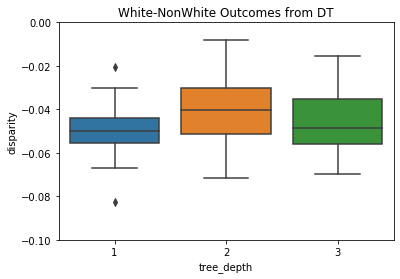

In [38]:
sns.boxplot(data=results_outcome, y='disparity', x='tree_depth')
plt.title('White-NonWhite Outcomes from DT')
plt.ylim([-0.1, 0])
plt.show()

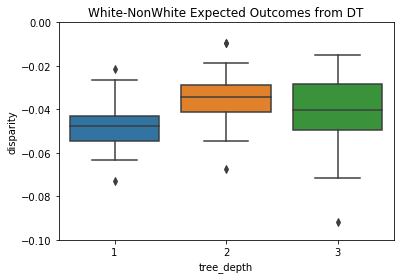

In [37]:
sns.boxplot(data=results_exp_outcome, y='disparity', x='tree_depth')
plt.title('White-NonWhite Expected Outcomes from DT')
plt.ylim([-0.1, 0])
plt.show()

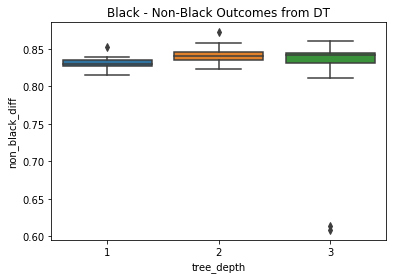

In [92]:
sns.boxplot(data=results_outcome, y='non_black_diff', x='tree_depth')
plt.title('Black - Non-Black Outcomes from DT')
plt.show()

In [ ]:
sns.boxplot(data=results_outcome, y='black_diff', x='tree_depth')
plt.title('Black - Non-Black Outcomes from DT')
plt.show()

In [53]:
results['disparity'] = results['non_black_diff'] - results['black_diff']

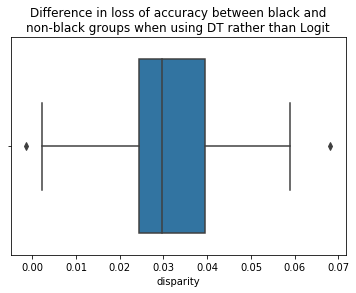

In [56]:
sns.boxplot(x=results['disparity'])
plt.title('Difference in loss of accuracy between black and\nnon-black groups when using DT rather than Logit')
plt.show()

In [3]:
seed = 1
split = 1
r = 0.33

In [5]:
fp_data = f'../data/Warfarin_v2/rf_balance_proba/seed{seed}'

In [6]:
df_train = pd.read_csv(os.path.join(fp_data, f'data_train_enc_{r}_{split}.csv'))
df_test = pd.read_csv(os.path.join(fp_data, f'data_test_enc_{r}_{split}.csv'))

df_train_raw = pd.read_csv(os.path.join(fp_data, f'data_train_{r}_{split}.csv'))
df_test_raw = pd.read_csv(os.path.join(fp_data, f'data_test_{r}_{split}.csv'))

Process OPT results and get outcomes

In [7]:
tree = {}
for d in [1, 2]:
    fp = f'Robust/seed{seed}/data_train_enc_{r}_{split}_Robust_d_{d}_t_3600_branching_limit_100.0_pred_tree.txt'
    with open(fp) as f:
        lines = [line.rstrip() for line in f]

    ids = []
    for idx, line in enumerate(lines):
        if '#########' in line:
            ids.append(idx)
            
    # create tree structure
    branching = []
    leaves = []
    if d == 1:
        assert len(ids) == 3

        branching.append(lines[ids[0]+1])
        leaves.append(lines[ids[1]+1][-1])
        leaves.append(lines[ids[2]+1][-1])

    elif d == 2:
        assert len(ids) == 7
        for i in range(3):
            branching.append(lines[ids[i]+1])
        for i in range(3, 7):
            leaves.append(lines[ids[i]+1][-1])
            
    tree[d] = {'branching': branching, 'leaves': leaves}

In [9]:
df_test['y_d1'] = df_test.apply(lambda row: split_d1(row, tree[1]['branching'], tree[1]['leaves']), axis=1)
df_test['y_d2'] = df_test.apply(lambda row: split_d2(row, tree[2]['branching'], tree[2]['leaves']), axis=1)

In [11]:
df_test_raw = rnc(df_train_raw, df_test_raw, LogisticRegression())
df_test['y_logit'] = df_test_raw.apply(lambda row: 1 if row['t_opt'] == row['t_pred'] else 0, axis=1)

/Users/nathanjo/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nathanjo/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Evaluate disparity between logit and OPT

In [15]:
evaluate_disparity(df_test, sensitive_group, 'y_logit', 'y_d1')

(0.014598540145985384, 0.05284227381905526)

In [16]:
evaluate_disparity(df_test, sensitive_group, 'y_logit', 'y_d2')

(0.007299270072992692, 0.04003202562049646)